In [1]:
import pymc3 as pm
import numpy as np
import theano

from theano.compile.ops import as_op

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.


In [2]:
def background_rate_f(b, T, n):
    """
    
    """
    out = 0
    #n = int(n)
    for i in range(n+1):
        out += ((b*T)**i * np.exp(- b*T)) / np.math.factorial(i)
    return out

def log_background_rate(b, T, n):
    return np.log(background_rate_f(b, T, n))

def signal_rate_part(s, n, b, T):
    top_a = T * ((s + b) * T)**n 
    top_b = np.exp(-(s + b)*T)
    p = (top_a * top_b) / np.math.factorial(n)
    return theano.tensor.switch(theano.tensor.le(s, 0), 0, p)

#@as_op(itypes=[T.dscalar, T.dscalar, T.dscalar, T.dscalar], otypes=[T.dscalar])
def log_signal_rate(s,n,b,T):
    #if theano.tensor.lt(0, s): return np.array([[0.0]])
    p = -log_background_rate(b,T,n) + np.log(signal_rate_part(s,n,b,T))
    
    return p

In [264]:
def number_mweg(horizon):
    return 4./3 * np.pi * horizon**3 *(2.26)**-3  #* (0.0116) #* horizon**3

In [265]:
import theano.tensor as T
from pymc3 import DensityDist, Uniform, Normal
from pymc3 import Model
from pymc3 import distributions


with Model() as model:
    number_events = 0
    background_rate = 0.01 #
    observation_time = 46.1/365. # 
    duty_cycle = 0.2
    horizon = 73.2    
    grb_rate = 1.0
    
    #trunc = pm.Bound(pm.DensityDist, lower=0)
    signal_rate = pm.DensityDist('signal_rate', 
                        logp=lambda value: log_signal_rate(value, number_events, background_rate, observation_time),
                       testval=10)
    
    n_galaxy = number_mweg(horizon)
    
    cbc_rate = pm.Deterministic('cbc_rate', signal_rate * n_galaxy * horizon)
    
    efficiency = pm.Uniform('efficiency', 0,1)
   
    costheta = pm.Deterministic('cos_angle', 1.0 - ((grb_rate/cbc_rate*efficiency)))
    
    angle = pm.Deterministic("angle", theano.tensor.arccos(costheta))

In [266]:
import theano.tensor as T
from pymc3 import DensityDist, Uniform, Normal
from pymc3 import Model
from pymc3 import distributions

def grb_model(number_events, background_rate, 
              observation_time, horizon, grb_rate,
             efficiency_prior = "uniform"):
    with Model() as model:
        signal_rate = pm.DensityDist('signal_rate', 
                            logp=lambda value: log_signal_rate(value, number_events, background_rate, observation_time),
                           testval=50)

        n_galaxy = number_mweg(horizon)

        cbc_rate = pm.Deterministic('cbc_rate', signal_rate * n_galaxy)

        # Allow the efficiency prior to be switched-out
        if efficiency_prior == "uniform":
            efficiency = pm.Uniform('efficiency', 0,1)
        elif efficiency_prior == "jeffreys":
            efficiency = pm.Beta('efficiency', 0.5, 0.5)
        elif isinstance(efficiency_prior, float):
            efficiency = efficiency_prior

        costheta = pm.Deterministic('cos_angle', 1.0 - ((grb_rate/cbc_rate*efficiency)))

        angle = pm.Deterministic("angle", theano.tensor.arccos(costheta))
        
        return model

In [274]:
# O1 Scenarios
number_events = 0 # There were no BNS detections in O1
background_rate = 0.01 # We take the FAR to be 1/100 yr
observation_time = 46.1/365. # The number of days of analysis conducted by gstLAL
horizon = 73.2  # The O1 BNS horizon distance in O1 BNS paper
grb_rate = 10.0

o1_model = grb_model(number_events, background_rate, observation_time, horizon, grb_rate, 1.0)

In [275]:
# O2 Scenarios
number_events = 1 # There were no BNS detections in O1
background_rate = 0.01 # We take the FAR to be 1/100 yr
observation_time = 0.5 # The number of days of analysis conducted by gstLAL
duty_cycle = 0.4
observation_time *= duty_cycle
horizon = 80.0  # The O1 BNS horizon distance in O1 BNS paper
grb_rate = 10.0

o2_model = grb_model(number_events, background_rate, observation_time, horizon, grb_rate, 1.0)

In [276]:
samples = 100000

In [277]:
with o1_model:
    step = pm.Metropolis()
    o1_trace = pm.sample(samples, step)
    
with o2_model:
    step = pm.Metropolis()
    o2_trace = pm.sample(samples, step)

100%|██████████| 100000/100000 [00:05<00:00, 16726.48it/s]


In [278]:
import matplotlib.pyplot as plt
%matplotlib inline

KeyError: 'efficiency'

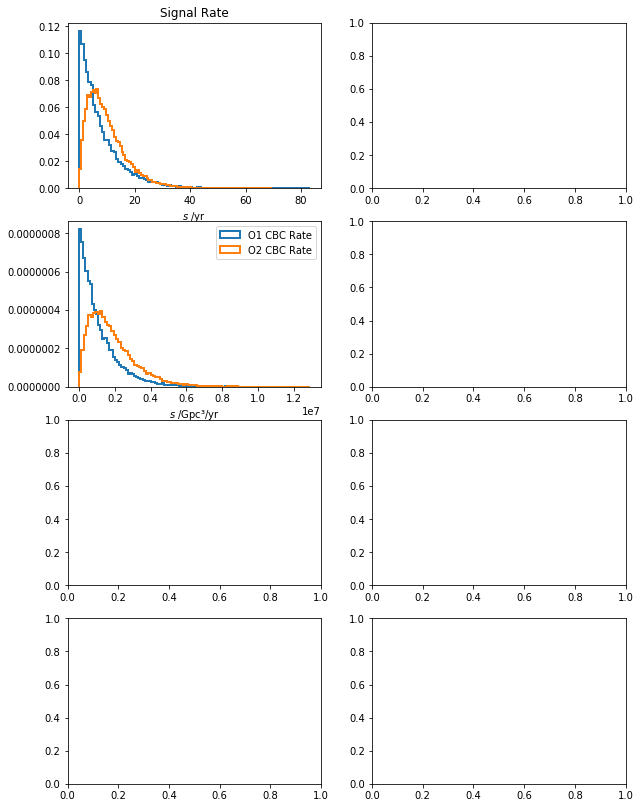

In [279]:
f, ax = plt.subplots(4,2, figsize = (10, 14))

ax[0,0].hist(o1_trace[2000:]['signal_rate'], histtype="step", 
             lw=2, normed=True, bins=100);
ax[0,0].hist(o2_trace[2000:]['signal_rate'], histtype="step", 
             lw=2, normed=True, bins=100);
#ax[0,0].vlines(np.percentile(trace['signal_rate'][2000:], 90), 0, 0.085,
#              label = "90% lower limit");
ax[0,0].set_title("Signal Rate");
ax[0,0].set_xlabel("$s$ /yr")

ax[1,0].hist(o1_trace[2000:]['cbc_rate'], histtype="step", lw=2, bins=100,
             normed=True, label="O1 CBC Rate");
ax[1,0].hist(o2_trace[2000:]['cbc_rate'], histtype="step", lw=2, bins=100,
             normed=True, label="O2 CBC Rate");
ax[1,0].set_xlabel(u"$s$ /Gpc³/yr");
#ax[1,0].vlines(np.percentile(o1_trace['cbc_rate'][2000:], 90), 0, 5e-5,
#              label = "90% lower limit, O1");
#ax[1,0].vlines(np.percentile(o2_trace['cbc_rate'][2000:], 90), 0, 5e-5,
#              label = "90% lower limit, O2", color="orange");
ax[1,0].legend()

ax[2,0].hist(o1_trace[2000:]['efficiency'], histtype="step", lw=2, label="Efficiency Rate");
ax[2,0].hist(o2_trace[2000:]['efficiency'], histtype="step", lw=2, label="Efficiency Rate");
#ax[1,0].set_xlabel(u"$s$ /Gpc³/yr")
ax[2,0].legend()

ax[3,0].hist(np.rad2deg(o1_trace[2000:]['angle'][np.isfinite(o1_trace[2000:]['angle'])]),
             histtype="step", lw=2, label="Angle", log=True);
ax[3,0].hist(np.rad2deg(o2_trace[2000:]['angle'][np.isfinite(o2_trace[2000:]['angle'])]),
             histtype="step", lw=2, label="Angle", log=True);
ax[3,0].vlines(np.percentile(np.rad2deg(o1_trace[2000:]['angle'][np.isfinite(o1_trace[2000:]['angle'])]), 90), 0, 3e5,
              label = "90% lower limit, O1");
ax[3,0].vlines(np.percentile(np.rad2deg(o2_trace[2000:]['angle'][np.isfinite(o2_trace[2000:]['angle'])]), 90), 0, 3e5,
              label = "90% lower limit, O2");
#ax[1,0].set_xlabel(u"$s$ /Gpc³/yr")
ax[3,0].legend()

In [ ]:
np.mean(o1_trace[2000:]['signal_rate'])

In [ ]:
print np.percentile(np.rad2deg(o1_trace[2000:]['angle'][np.isfinite(o1_trace[2000:]['angle'])]), 10)
print np.percentile(np.rad2deg(o1_trace[2000:]['angle'][np.isfinite(o1_trace[2000:]['angle'])]), 90)

In [280]:
print np.percentile(o1_trace['cbc_rate'], 90)

2620349.35454


In [ ]:
np.mean(np.rad2deg(o1_trace[2000:]['angle'][np.isfinite(o1_trace[2000:]['angle'])]))

In [262]:
pm.summary(o1_trace)


signal_rate:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  8.125            8.213            0.106            [0.001, 24.523]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.227          2.356          5.586          11.111         30.656


cbc_rate:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  13414.644        13559.453        174.380          [1.650, 40488.949]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  374.027        3889.018       9222.781       18344.540      50613.349


cos_angle:

  Mean             SD               MC Error         95% HPD interval
  --

In [263]:
np.rad2deg(0.047)

2.6929016371148693

In [218]:
pm.summary(o2_trace)


signal_rate:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  10.002           7.234            0.075            [0.175, 24.062]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.226          4.785          8.327          13.361         28.440


cbc_rate:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  21451480.419     15515154.174     161434.702       [374880.923, 51605064.539]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  2628492.801    10263188.805   17859212.128   28654201.795   60993846.534


cos_angle:

  Mean             SD               MC Error         95% HPD in